In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.api import ProbPlot

%config InlineBackend.figure_format ='retina'

sns.set_style("whitegrid")

# Sampling

My notes from working through section 2, data and sampling distributions, of [Practical statistics for data science](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/), to revise consepts and get comfortable implementing them in Python.

## Sampling

- We rely on a sample to learn about a larger population.
- We thus need to make sure that the sampling procedure is free of bias, so that units in the sample are representative of those in the population.
- While representativeness cannot be achieved perfectly, it's important to ensure that non-representativeness is due to random error and not due to systematic bias.
- Random errors produce deviations that vary over repeated samples, while systematic bias persists. Such selection bias can lead to misleading and ephemeral conclusions.
- Two basic sampling procedures are simple random sampling (randomly select $n$ units from a population of $N$) and stratified random sampling (randomly select $n_s$ from each stratum $S$ of a population of $N$).
- The mean outcome of the sample is denoted $\bar{x}$; that of the population, $\mu$.

## Selection bias

Common types of selection bias in data science:
- The vast search effect (using the data to answer many questions will eventually reveal something interesting by mere chance -- if 20,000 people flip a coin 10 times, some will have 10 straight heads)
- Nonrandom sampling
- Cherry-picking data
- Selecting specific time-intervals
- Stopping experiments prematurely
- Regression to the mean (occurs in settings where we measure outcomes repeatedly over time and where luck and skill combine to determine outcomes, since winners of one period will be less lucky next period and perform closer to the mean performer)

Ways to guard against selection bias:
- have one or many holdout datasets to confirm your results. 

## Sampling distributions

- A sampling distribution is the distribution of a statistic (e.g. the mean) over many repeated samples. Classical statistics is much concerned with making inferences from samples about the population based on such statistics.
- When we measure an attribute of the population based on a sample using a statistic, the result will vary over repeated samples. To capture by how much it varies, we are concerned with the sampling variability.

- Key distinctions:
    - The data distribution is the distribution of the data in the sample, and its spread is measured by the standard deviation.
    - The sampling distribution is the distribution of the sample statistic, and its spread is measured by the standard error.

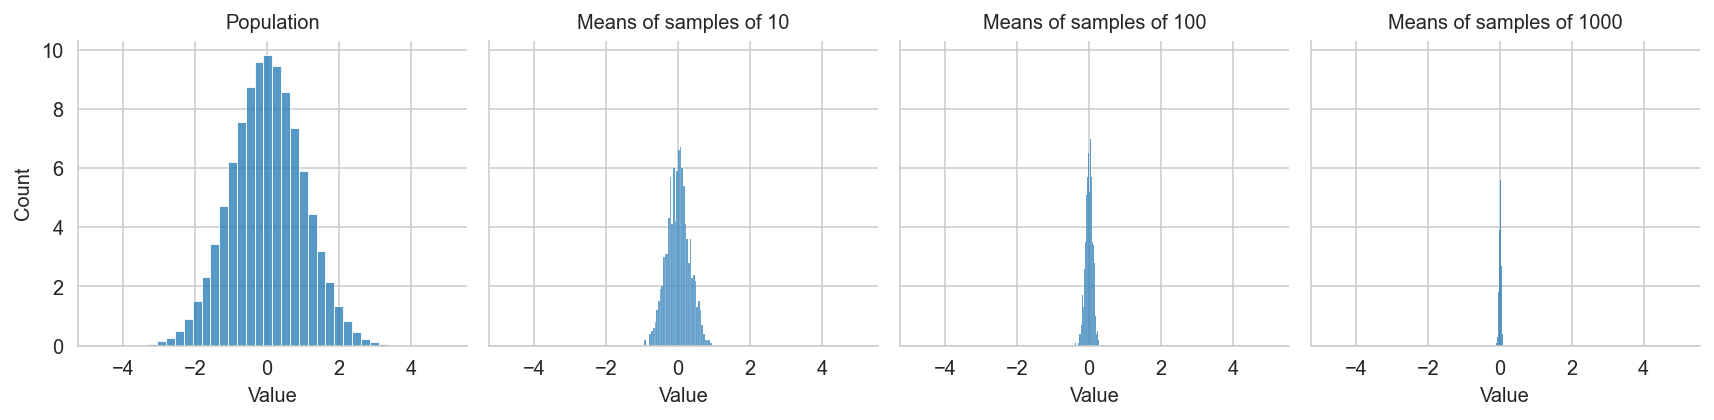

In [4]:
rng = np.random.default_rng(2312)


def means(data, sample_size, num_means=1000):
    return rng.choice(data, (sample_size, num_means)).mean(0)


# Create dataset with population and sample data
data = pd.DataFrame({"Population": rng.normal(size=1_000_000)})
for n in [10, 100, 1000]:
    data = data.join(
        pd.Series(means(data.Population, n), name=f"Means of samples of {n}")
    )
data = data.melt()


g = sns.FacetGrid(data, col="variable")
g.map(sns.histplot, "value", bins=40, stat="percent")
g.set_axis_labels("Value", "Count")
g.set_titles("{col_name}");

Plots show that:
- Data distribution has larger spread than sampling distributions (each data point is a special case of a sample with n = 1)
- The spread of sampling distributions decreases with increasing sample size

## Law of large numbers and central limit theorem

- Suppose that we have a sequence of independent and identically distributed (iid) random variables $\{x_1, ..., x_n\}$ drawn from a distribution with expected value $\mu$ and finite variance $\sigma^2$, and we are interested in the mean value $\bar{x} = \frac{x_1 + ... + x_n}{n}$.

- The law or large numbers states that $\bar{x}$ converges to $\mu$ as we increase the sample size. Formally: 

$$
\bar{x} \rightarrow \mu \text{ as } n \rightarrow \infty.
$$

- The (classical, Lindeberg-Lévy) central limit theorem describes the spread of the sampling distribution of $\bar{x}$ around $\mu$ during this convergence. In particular, it states that for large enough $n$, the distribution of $\bar{x}$ will be close to a normal distribution with mean $\mu$ and variance $\sigma^2/n$. The above figures are a visual representation of this. Formally:

$$
\lim _{n\to\infty} \sqrt{n}(\bar{x} - \mu) \rightarrow \mathcal{N}\left(0,\sigma ^{2}\right).
$$

- This is useful because it means that irrespective of the underlying distribution (i.e. the distribution of the values in our sequence above), we can use the normal distribution and approximations to it (such as the t-distribution) to calculate sample distributions when we do inference. Because of this, the CLT is at the heart of the theory of hypothesis testing and confidence intervals, and thus of much of classical statistics.

- For experiments, this means that our estiamted treatment effect is normally distributed, which is what allows us to draw inferences from our experimental setting ot the population as a whole. The CLT is thus at the heart of the experimental approach.

- The CLT also explains the prevalence of the normal distribution in the natural world. Many characteristics of living things we observe and measure are the sum of the additive effects of many genetic and environmental factors, so their distribution tends to be normal.

## Standard error

- The standard error is a measure for the variability of the sampling distribution. 
- It is related to the standard deviation of the observations, $\sigma$ and the sample size $n$ in the following way:

$$
se = \frac{\sigma}{\sqrt{n}}
$$

- The relationship between sample size and se is sometimes called the "Square-root of n rule", since reducing the $se$ by a factor of 2 requires an increase in the sample size by a factor of 4.

Derivation:

The sum of a sequence of independent random variables is:

$$
T = (x_1 + x_2 + ... + x_n)
$$

Which has variance

$$
Var(T) = Var(x_1) + Var(x_2) + ... + Var(x_n) = n\sigma^2$$

and mean

$$
\bar{x} = T/n.
$$

The variance of $\bar{x}$ is then given by:

$$
Var(\bar{x}) = Var\left(\frac{T}{n}\right) = \frac{1}{n^2}Var(T) = \frac{1}{n^2}n\sigma^2 = \frac{\sigma^2}{n}.
$$

The standard error is defined as the standard deviation of $\bar{x}$, and is thus

$$
se(\bar{x}) = \sqrt{Var(\bar{x})} = \frac{\sigma}{\sqrt{n}}.
$$




## Degrees of freedom

- The number of parameters you had to estimate en route to calculate the desired statistic ([source](http://onlinestatbook.com/2/estimation/df.html)). If you calculate sample variance with an estimated mean rather than a known mean, you have to estimate the sample mean first and thus loose 1 degree of freedom. Hence, you'd divide the sum of squared deviations from the (estimated) mean by n-1 rather than n.

## Bootstrap

- In practice, we often use the bootstrap to calculate standard errors of model parameters or statistics.
- Conceptually, the bootstrap works as follows: 1) we draw an original sample and calculate our statistic, 2) we then create a blown-up version of that sample by duplicating it many times, 3) we then draw repeated samples from the large sample, recalculate our statistic, and calculate the standard deviation of these statistics to get the standard error.
- To achieve this easily, we can skip step 2) by simply sampling with replacement from the original distribution in step 3).
- The full procedure makes clear what the bootstrap results tell us, however: they tell us how lots of additional samples would behave if they were drawn from a population like our original sample.
- Hence, if the original sample is not representative of the population of interest, then bootstrap results are not informative about that population either.
- The bootstrap can also be used to improve the performance of classification or regression trees by fitting multiple trees on bootstrapped sample and then averaging their predictions. This is called "bagging", short for "bootstrap aggregating".


In [47]:
from sklearn.utils import resample

rng = np.random.default_rng(2312)

population = rng.normal(3, 5, 1_000_000)
sample = rng.choice(population, 1000)
resample_means = pd.Series(resample(sample).mean() for _ in range(1000))

print(f"{'Population mean:':20} {np.mean(population):.3f}")
print(f"{'Sample mean:':20} {np.mean(sample):.3f}")
print(f"{'Bootstrap mean:':20} {np.mean(resample_means.mean()):.3f}")
print(f"{'Bootstrap se:':20} {np.mean(resample_means.std()):.3f}")

Population mean:     2.999
Sample mean:         2.999
Bootstrap mean:      2.999
Bootstrap se:        0.161


## Confidence intervals

- A CI is another way to learn about the variability of a test statistic. 
- It can be calculated using the (standard) normal distribution or the t-distribution (if sample sizes are small).
- But for data science purposes we can compute an x-percent CI from the bootstrap, following this algorithm: 1) Draw a large number of bootstrap samples and calculate the statistic of interest, 2) Trim [(100-x)/2] percent of the bootstrap results on either end of the distribution, 3) the trim points are the end point of the CI.